In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")


In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Inspect the Data

In [9]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fcee65b1dc0>,
 'tobs': 65.0,
 'id': 1,
 'date': '2010-01-01',
 'station': 'USC00519397',
 'prcp': 0.08}

In [10]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [11]:
# Using the inspector to print the column names within the measurement table and its types

columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Using the inspector to print the column names within the station table and its types

columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [23]:
# Find the most recent date in the data set

recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
days365 = dt.date(2017, 8, 23) - dt.timedelta(days=365)

recent_date


('2017-08-23')

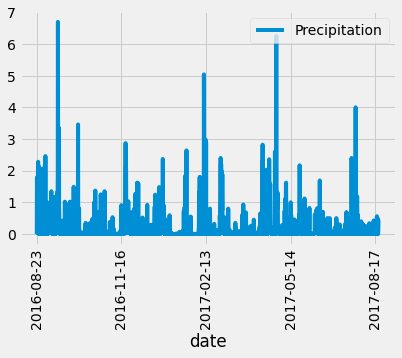

In [24]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores

prcp_date = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23').\
filter(Measurement.date <= '2017-08-23').all()



# Save the query results as a Pandas DataFrame and set the index to the date column

prcp_df = pd.DataFrame(prcp_date).set_index('date')
prcp_df = prcp_df.rename(columns={'prcp': 'Precipitation'})
prcp_df.head()

# Sort the dataframe by date
prcp_df = prcp_df.sort_values('date').dropna()
prcp_df.head()

# Use Pandas Plotting with Matplotlib to plot the data

prcp_df.plot()
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.show()


In [25]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [26]:
# Design a query to calculate the total number stations in the dataset

number_of_stations = session.query(Station.id).count()
number_of_stations

9

In [27]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

# write out in standard sql to help me keep track

# active_stations = engine.execute("select station, count(station)\
# from measurement group by station order by count(station) desc;")

active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                  group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
                                

active_stations.all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [28]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# write out in standard sql to help me keep track
#engine.execute("select min(tobs), max(tobs), avg(tobs) from measurement where station = 'USC00519281';").fetchall()

session.query(func.min(Measurement.tobs), 
              func.max(Measurement.tobs),
              func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()



[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 0, 'Temperature')

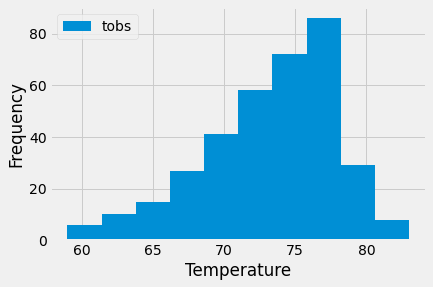

In [29]:
# Using the most active station id
# Query the last 12 months of temperature observation data 
#for this station and plot the results as a histogram

year_most_active_station = session.query(Measurement.date, Measurement.tobs)\
.filter(Measurement.date >= '2016-08-23').filter(Measurement.date <= '2017-08-23').\
filter(Measurement.station == 'USC00519281').all()

df = pd.DataFrame(year_most_active_station).dropna()


df.head(50)

df.plot.hist()
plt.xlabel("Temperature")



# Close session

In [20]:
# Close Session
session.close()